# Somewhat realistic industrial machinery simulation for Predictive Maintenance

## Introduction

In a nutshell, Predictive Maintenance (PdM) is aimed at scheduling appropriate corrective actions to avoid unexpected equipment failures. This may come as a surprise, but PdM is a relatively old and well-developed field with a substantial body of research and techniques that pre-date any commercially-viable AI. Currently, there's a solid number of large- and small-scale service providers offering comprehensive and partial solutions, some of which are infused with AI. *(Frankly, this is mostly bad news for us, but also, hopefully, a much needed wake-up call for technical and business course-correction. But let's move on; this is a Jupyter notebook after all!)*

## Telemetry: tools and techniques

**Vibration analysis** is one of the foundational and most commonly used tools in any Predictive Maintenane scenario involving mechanical equipment. As the guy in the video below nicely puts it: "giving machines a voice so we can listen and determine if the machine needs attention" is the essence of vibration analysis in the context of PdM.

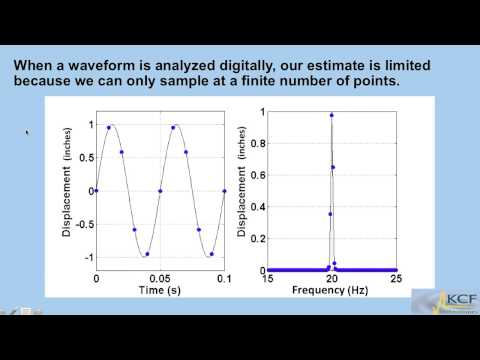

In [1]:
from IPython.display import YouTubeVideo
display(YouTubeVideo("rLpKnx0pUEE"))

This [blog post](https://blog.mide.com/6-ways-to-measure-vibrations) provides a few insights into existing vibration analysis and monitoring equipment. We will disregard most of the technicalities except the ones dictating some of the underlying assumptions for our Cloud-based PdM solution. Namely:

- Sample rate (10Hz - 51.2kHz)
- Storage size (maximum number of samples the sensor can keep in memory)

These characteristics determine the format of the input data, and therefore are crucial.

The sensors (typically, piezoelectric accelerometers) are statically mounted onto a piece of equipment and their positioning is extremely important.
![](http://www.imi-sensors.com/contentstore/mktg/IMI%20Website%20Images/InfoGraphics/CoolingTowers/InfoGraphic-CoolingTower-MotorILLUS.jpg)

The output of each sensor is a pulse-code modulation (PCM) of the analog signal representing the vibration of the piece equipment at a certain spot. Typically, the signal has one dimension determined by the sensor's placement.

### Other types of sensor data

Sensors collecting other types of operational metrics may be employed in a PdM solution. Some of the possible measurements are:
- ambient light
- sound
- magnetic field
- humidity
- pressure
- object temperature
- ambient temperature

### IoT Edge

The sensor data, along with the values describing the machine's current mode of operation (for instance, rotational speed or RPM for rotating equipment), is collected (and, sometimes, aggregated and analyzed) at an IoT Edge device. The Edge device periodically transmits the data, with or without preprocessing, to the cloud where it's used for predictive analysis.

## Simulation

In order to produce a sufficiently large simulated dataset that resembles a possible real-world scenario for model training, and also to demonstrate how the model performs in a fully operationalized environment, we will develop a method for simulating sensor data that could have been collected from some sort of rotating machinery.

### Sensor

Our machine is equipped with a vibration sensor capable of capturing 10 seconds' worth of data at 8kHz. 

In [2]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import numpy as np
from IPython.display import Audio
from scipy.interpolate import interp1d
from scipy import signal

fs = 8000 # 8kHz
length = 10
N = fs * length

### Machine's basic mode of operation
Let's assume the machine has an engine, which at any point in time has a certain instant speed expressed in revolutions per minute (RPM). This speed can vary; i.e., the engine may start, stop, gradually accelerate or decelerate.

In the example below, by means of cubic interpolation, we generate a sample function describing the machine's mode of operation over time.

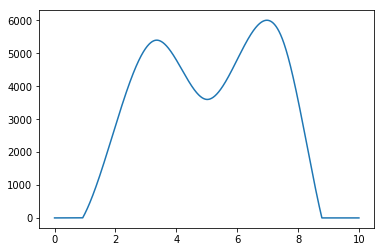

In [3]:
t = np.linspace(0, length, num = N, endpoint = False)

x = [0, length / 6, length / 3, length /2, length * 3 / 4 ,length * 6 / 7, length]
points = np.array([0, 1800, 5400, 3600, 5400, 900, 0])

rpm = interp1d(x, points, kind='cubic') 

f = rpm(t)

# interpolation is not positive-preserving
f[f < 0] = 0

plt.plot(t, f)
plt.show()

### Simulated vibration sensor signal

The frequency and amplitude of vibration harmonic components are correlated with the machine's basic mode of operation. With the help of spectral modeling synthesis (SMS) techniques, we can simulate vibration sensor's signal as a function of the engine's rotational speed. For simplicity, we will reasonably assume this relationship is linear (which may not be the case for complex machinery with gears).

The sensor signal can be produced by combining harmonic components expressed as canonical sine wave functions with a zero phase shifts. For the sake of "realism," we also add a hint of Gaussian white noise to the mix.

$$Y(t) = \sum\limits_k A_k\sin(2\pi f_kt) + g(t)$$

The above formula works when the frequency is constant. In our case, however, it's a time-varying function. In order to accomodate for that we perform frequency modulation: 

$$Y(t) = \sum\limits_k A_k\sin(2\pi \int\limits_0^t f_k(t)dt) + g(t)$$


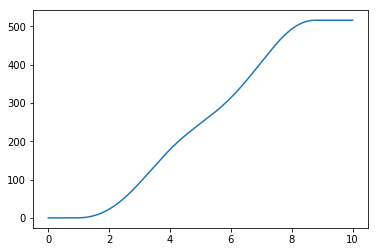

In [4]:
fi = np.cumsum(f/fs)/60
plt.plot(t, fi)
plt.show()

In [5]:
wk = [1, 2, 3, 5, 12, 7, 1/2, 18]
Ak = [5, 80, 2/3, 8, 14, 2, 1, 50]

def generate(fi, wk, Ak, s = None):
    N = len(fi)
    base = 2 * np.pi * fi
    b = np.array([np.sin(base * w) * a for w, a in zip(wk, Ak)])
    a = b.sum(axis = 0)
    a = np.random.normal(-0.5, 0.5, N) + a
    if s is not None:
        a += s
    return np.int16(a/np.max(np.abs(a)) * 32767)

signal_pcm = generate(fi, wk, Ak)

Audio(signal_pcm, rate = fs , autoplay=False)

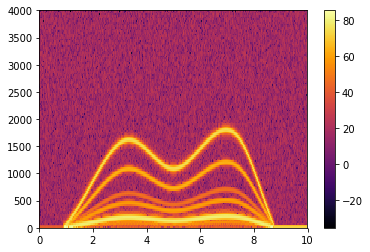

In [6]:
def spectrogram(signal):
    fig, ax = plt.subplots()
    cmap = plt.get_cmap('inferno')
    cmap.set_under(color='k', alpha=None)
    Pxx, freqs, bins, im = ax.specgram(signal, Fs=fs, NFFT=256, cmap = cmap, mode='magnitude')
    fig.colorbar(im)
    plt.show()
    
spectrogram(signal_pcm)

In [7]:
wk = [1/2, 1, 2,  3,  5, 7, 12, 18, 20]
Ak = [100,   500, 80, 5, 8, 2, 1, 5, 1]

signal_pcm_alt = generate(fi, wk, Ak)

Audio(signal_pcm_alt, rate = fs , autoplay=False)

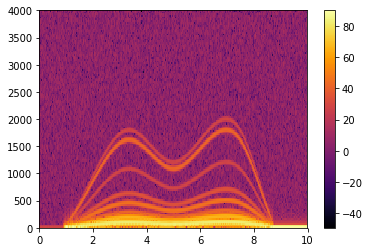

In [8]:
spectrogram(signal_pcm_alt)

Possible electric malfunctions, a short cirquit.

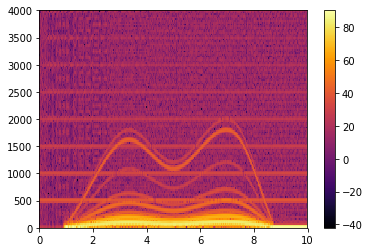

In [9]:
signal_pcm_alt = generate(fi, wk, Ak, signal.sawtooth(2 * np.pi * 500 * t) * 5)
spectrogram(signal_pcm_alt)

In [10]:
Audio(signal_pcm_alt, rate = fs , autoplay=False)